# Importing Libraries

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time

* Pandas Options

In [3]:
pd.set_option('max_columns', None)

* Source Code

In [4]:
from Source.Utils import welllog
from Source.Utils import multi_df
from Source.Utils import well_plot

* Tqdm Progress Bar

In [5]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint import

In [6]:
total_df = pd.read_csv('../checkpoints/litho_data_3.csv.gz', compression='gzip') # already non-null litho classes

In [7]:
total_df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME,DRDN,AI,LITHOLOGY_GEOLINK_2,LITHOLOGY_GEOLINK_3
0,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,6,2215.917725,15_9-12,7.184164,317.241248,5,5
1,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,6,2216.070068,15_9-12,6.203159,302.098359,5,5
2,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,6,2216.222412,15_9-12,4.952206,283.411635,5,5
3,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,6,2216.375000,15_9-12,4.664760,268.071435,5,5
4,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,6,2216.527344,15_9-12,5.164095,262.514429,5,5


In [8]:
total_df['LITHOLOGY_GEOLINK_2'] = total_df['LITHOLOGY_GEOLINK']

for code in tqdm_notebook(total_df.index, desc='Regrouping lithologies'):

    if (total_df['LITHOLOGY_GEOLINK_2'][code] == 2 or total_df['LITHOLOGY_GEOLINK_2'][code] == 3):

        total_df['LITHOLOGY_GEOLINK_2'][code] = 1

    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 6:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 5

    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 34:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 33


    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 13:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 12

    else:
        
        pass

# Lithology Code Prediction

* LITHOLOGY_GEOLINK non NULL data

In [9]:
#litho_data = total_df.drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK_2', 'LITHOLOGY_GEOLINK_3', 'DRDN', 'AI']) # litho1 optimum set (84.9)

litho_data = total_df.drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK', 'LITHOLOGY_GEOLINK_3', 'DRDN', 'AI']) # litho2 optimum set (84.5)

# litho_data = total_df.drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK_2', 'LITHOLOGY_GEOLINK']) # litho3 optimum set

litho_data.head(n=5)

,CALI,NPHI,RHOB,GR,DTC,RDEP,DEPTH,LITHOLOGY_GEOLINK_2
0,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,2215.917725,5
1,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,2216.070068,5
2,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,2216.222412,5
3,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,2216.375000,5
4,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,2216.527344,5


In [10]:
len(litho_data)

1294715

    * Converting LITHOLOGY_GEOLINK to int type

In [11]:
litho_data['LITHOLOGY_GEOLINK_2'] = litho_data['LITHOLOGY_GEOLINK_2'].astype(int)

    * Checking classes balance

In [12]:
unsorted_bal_class = dict(Counter(litho_data['LITHOLOGY_GEOLINK_2'].values))

sorted_bal_class = {k: v for k, v in sorted(unsorted_bal_class.items(), key=lambda item: item[1])}

sorted_bal_class # although some classes have a considerable less representation than others, we need to respect this distribution to maintain the geological setting of the area

{26: 737,
 33: 815,
 22: 826,
 17: 1744,
 15: 3076,
 18: 5042,
 10: 9733,
 21: 10097,
 9: 12352,
 16: 26373,
 19: 30511,
 4: 47267,
 11: 48710,
 7: 96926,
 12: 194220,
 1: 196580,
 5: 609706}

    * Pearson Correlation

In [13]:
# corrmat_litho = abs(litho_data.corr()) # absolute correlation

# plt.figure(figsize=(25,15))

# sns.heatmap(corrmat_litho, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap='Blues')

    * Dataset Creation

In [14]:
from sklearn.model_selection import train_test_split

X = litho_data.drop(columns='LITHOLOGY_GEOLINK_2')

Y = litho_data['LITHOLOGY_GEOLINK_2'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

In [15]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (647357, 7) (647357,)
### Test Dataset: ###  (647358, 7) (647358,)


    * Model Selection

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, cross_validate

# class_pipelines = []

# class_pipelines.append(('ScaledRidge', Pipeline([('Scaler', RobustScaler()),('Ridge', linear_model.RidgeClassifier())])))
# class_pipelines.append(('ScaledSGDCls', Pipeline([('Scaler', RobustScaler()),('SGDCls', linear_model.SGDClassifier(n_jobs=60))])))
# class_pipelines.append(('ScaledKNNCls', Pipeline([('Scaler', RobustScaler()),('KNNCls', KNeighborsClassifier(n_jobs=60))])))
# class_pipelines.append(('ScaledDTC', Pipeline([('Scaler', RobustScaler()),('DTC', DecisionTreeClassifier())])))
# class_pipelines.append(('ScaledRFC', Pipeline([('Scaler', RobustScaler()),('RFC', RandomForestClassifier(n_jobs=60))])))
# class_pipelines.append(('ScaledADA', Pipeline([('Scaler', RobustScaler()),('ADA', AdaBoostClassifier())])))


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

# results = []

# names = []

# for name, model in tqdm_notebook(class_pipelines, desc='Cross-Validation Procedure'):

#     kfold = KFold(n_splits=5, random_state=42)

#     scorers = {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score), 'precision': make_scorer(precision_score, average='micro'), 'recall': make_scorer(recall_score, average='micro'), 'f1': make_scorer(f1_score, average='weighted')}

#     final_scorers = cross_validate(model, x_train, y_train, cv=kfold, scoring=scorers)
#     results.append(final_scorers)
#     names.append(name)
#     print(name, 'Acc: ', final_scorers['test_accuracy'].mean(), '\\', final_scorers['test_accuracy'].std(), '\n')
#     print(name, 'BalAcc: ', final_scorers['test_balanced_accuracy'].mean(), '\\', final_scorers['test_balanced_accuracy'].std(), '\n')
#     print(name, 'F1: ', final_scorers['test_f1'].mean(), '\\', final_scorers['test_f1'].std(), '\n')


    * Hyperparameter Tunning

In [18]:
# start_time = time.time()

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rfc = RandomForestClassifier(n_jobs=60)

# kfold = KFold(n_splits=5, random_state=42)

# rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = kfold, verbose=10, random_state=42, scoring='balanced_accuracy')

# rfc_random.fit(RobustScaler().fit_transform(x_train), y_train)

# print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 


In [19]:
# result_cv = pd.DataFrame.from_dict(rfc_random.cv_results_)

# result_cv.to_csv('../models/results/rand_search_rfc.csv')

In [20]:
start_time = time.time()

best_rfc = RandomForestClassifier(max_depth=40, n_estimators=1400, max_features='auto', min_samples_split=2, bootstrap=False, n_jobs=60) # the rest of the best parameters are  the default ones

best_rfc.fit(RobustScaler().fit_transform(x_train), y_train)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

5.8 minutes taken


    * Model Accuracy Test

In [21]:
start_time = time.time()

y_predict = best_rfc.predict(RobustScaler().fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

3.0 minutes taken


In [22]:
print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('########################', '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('########################', '\n')
print('F1-Score Micro: ', str(f1_score(y_test, y_predict, average='weighted')))

Accuracy:  0.9112932874854408 

######################## 

Balanced Accuracy:  0.844869473076505
######################## 

F1-Score Micro:  0.9085809135769153


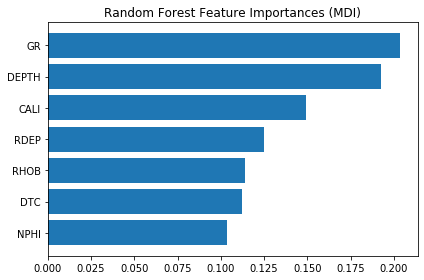

In [23]:
tree_feature_importances = (best_rfc.feature_importances_)
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

    * Confusion Matrix

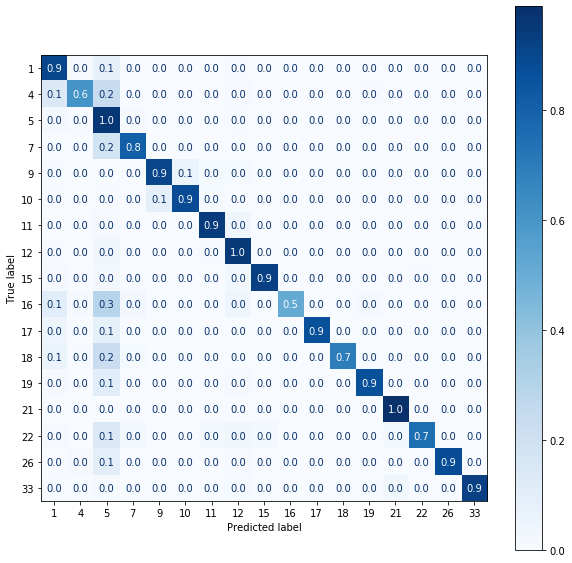

In [24]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(best_rfc, RobustScaler().fit_transform(x_test), y_test, normalize='true', cmap=plt.cm.Blues, ax=ax, values_format='.1f')

plt.show()

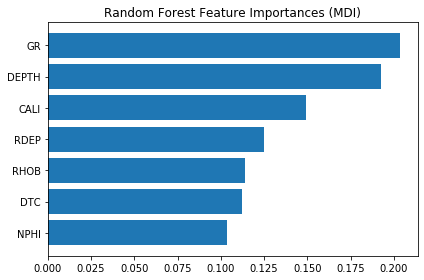

In [25]:
tree_feature_importances = best_rfc.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

    * Null Values Prediction

        * Null Values Dataset 

null_litho_dataset = total_df[pd.isnull(total_df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK'])

        * Prediction

litho_prediction = best_rfc.predict(RobustScaler().fit_transform(null_litho_dataset))

        * Replacing Null Values for Predicted Ones

predicted_litho_dataset = null_litho_dataset

predicted_litho_dataset['LITHOLOGY_GEOLINK'] = litho_prediction

predicted_litho_dataset.head(n=5)

    * Final Dataframe

final_df = litho_data.append(predicted_litho_dataset)

final_df.sort_index(inplace=True)

final_df['WELL_NAME'] = total_df['WELL_NAME'].values

final_df.head(n=5)

# Checkpoints

path_file_final_df = '../checkpoints/final_df.csv.gz'

final_df.to_csv(path_file_final_df,index=False, compression='gzip')